In [2]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from torch.utils.data import Dataset, DataLoader

In [3]:
df_training = pd.read_hdf('./NSubjetiness_TopData/train_subjettiness.h5', key='table')
df_val = pd.read_hdf('./NSubjetiness_TopData/val_subjettiness.h5', key='table')
df_test = pd.read_hdf('./NSubjetiness_TopData/test_subjettiness.h5', key='table')
keys = df_training.keys()

In [4]:
mean_values = []
std_values = []
for k in range(27):
    mean_values.append(np.mean(df_training[keys[k]]))
    std_values.append(np.std(df_training[keys[k]]))
    df_training[keys[k]] = (df_training[keys[k]] - mean_values[k]) / std_values[k]
    df_val[keys[k]] = (df_val[keys[k]] - mean_values[k]) / std_values[k]
    df_test[keys[k]] = (df_test[keys[k]] - mean_values[k]) / std_values[k]

In [5]:
def removeNaN(df):
    rm_ind = []
    for i in range(len(df)):
        if(i % 5000 == 0):
            print(i / len(df) * 100)
        for j in range(len(keys)):
            if not df.iloc[i][j] == df.iloc[i][j]:
                print("yes", i, j)
                rm_ind.append(i)
    for j in range(len(rm_ind)):
        df.drop(df.index[rm_ind[len(rm_ind)-j]], inplace=True)

In [6]:
#removeNaN(df_training)
#removeNaN(df_val)
#removeNaN(df_test)

In [7]:
df_training.drop(df_training.index[456856], inplace=True)
df_val.drop(df_val.index[199765], inplace=True)
df_test.drop([df_test.index[80126], df_test.index[49496]], inplace=True)

In [50]:
df_test.to_csv(r'./data/test_data.txt')
df_training.to_csv(r'/home/tore/Uni/Sem6/Bachelorarbeit/data/train_data.txt')
df_val.to_csv(r'/home/tore/Uni/Sem6/Bachelorarbeit/data/val_data.txt')

In [8]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("running on GPU")
else:
    print("running on CPU")
    dev = "cpu"
    
device = torch.device(dev)

running on CPU


In [9]:
print(keys)

Index(['1_subjettiness_0.5', '1_subjettiness_1.0', '1_subjettiness_2.0',
       '2_subjettiness_0.5', '2_subjettiness_1.0', '2_subjettiness_2.0',
       '3_subjettiness_0.5', '3_subjettiness_1.0', '3_subjettiness_2.0',
       '4_subjettiness_0.5', '4_subjettiness_1.0', '4_subjettiness_2.0',
       '5_subjettiness_0.5', '5_subjettiness_1.0', '5_subjettiness_2.0',
       '6_subjettiness_0.5', '6_subjettiness_1.0', '6_subjettiness_2.0',
       '7_subjettiness_0.5', '7_subjettiness_1.0', '7_subjettiness_2.0',
       '8_subjettiness_0.5', '8_subjettiness_1.0', '8_subjettiness_2.0', 'm',
       'pT', 'truthE', 'truthPX', 'truthPY', 'truthPZ', 'ttv',
       'is_signal_new'],
      dtype='object')


In [10]:
input_vec = df_training[keys[0:-6]]
training_input = torch.tensor(input_vec.values).to(device)
val_input = torch.tensor(df_val[keys[0:-6]].values).to(device)

labels = df_training[keys[-1]]
training_labels = torch.tensor(labels.values).to(device)
val_labels = torch.tensor(df_val[keys[-1]].values).to(device)

torch.reshape(training_labels, (len(training_labels), 1))
torch.reshape(val_labels, (len(val_labels), 1))

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [13]:
model = torch.nn.Sequential(
    torch.nn.Linear(26, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1),
    torch.nn.Sigmoid()
)

model = model.to(device)
loss_fn = torch.nn.BCELoss()

In [14]:
learning_rate = 0.1
epochs = 50

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epoch: 0, loss: 0.6639, accuracy: 0.6409, AUC: 0.7795, background rejection at 30 percent: 9.6448


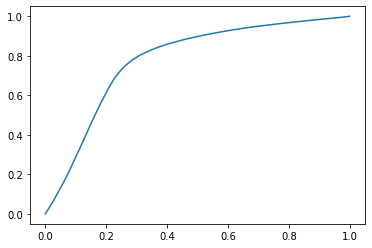

In [15]:
loss_train_arr = []
loss_val_arr = []
acc_arr = []
auc_arr = []
bkg_rej = []
for e in range(epochs):
    torch.cuda.empty_cache()
    label_pred = model(training_input)
    loss_train = loss_fn(label_pred, training_labels.reshape(-1, 1))
    
    with torch.no_grad():
        val_label_pred = model(val_input)
        loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
        acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
        loss_train_arr.append(loss_train.item())
        loss_val_arr.append(loss_val.item())
        auc_arr.append(roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy()))
        fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
        bkg_rej.append(1/fpr[np.argmin(np.abs(tpr-0.3))])
        if e % 50 == 0:
            print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f, background rejection at 30 percent: %.4f" % (e, loss_train.item(), acc_arr[e], auc_arr[e], bkg_rej[e]))
            plt.plot(fpr, tpr) 
            
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

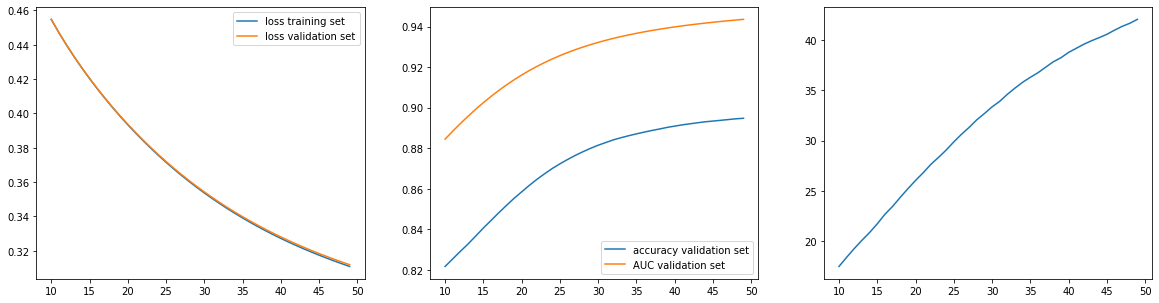

In [16]:
cut_epochs = 10

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(range(epochs)[cut_epochs:], loss_train_arr[cut_epochs:], label='loss training set')
ax1.plot(range(epochs)[cut_epochs:], loss_val_arr[cut_epochs:], label='loss validation set')
ax1.legend(loc='upper right')
ax2.plot(range(epochs)[cut_epochs:], acc_arr[cut_epochs:], label='accuracy validation set')
ax2.plot(range(epochs)[cut_epochs:], auc_arr[cut_epochs:], label='AUC validation set')
ax2.legend(loc='lower right')
ax3.plot(range(epochs)[cut_epochs:], bkg_rej[cut_epochs:])
plt.show()

In [17]:
with torch.no_grad():
    test_input = torch.tensor(df_test[keys[0:-6]].values).to(device)
    test_labels = torch.tensor(df_test[keys[-1]].values).to(device)
    test_label_pred = model(test_input)
    print("accuracy test set: %.4f" % (1 - torch.sum(torch.abs(test_label_pred.round() - test_labels.reshape(-1, 1))).item()/len(test_labels)))
    print("AUC test set: %.4f" % (roc_auc_score(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())))
    fpr, tpr, thresholds = roc_curve(val_labels.cpu().detach().numpy(), val_label_pred.cpu().detach().numpy())
    print("background rejection at 30 percent: %.4f" % (1/fpr[np.argmin(np.abs(tpr-0.3))]))

accuracy test set: 0.8958
AUC test set: 0.9435
background rejection at 30 percent: 42.0441


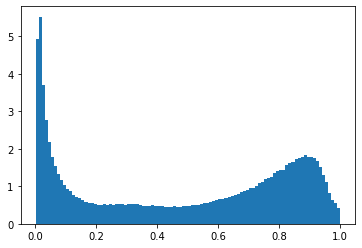

In [18]:
plt.hist(test_label_pred.detach().numpy(), density=True, bins=100)
plt.show()